Add folder with images from drive

We are going to start by importing some basic libraries to start working with our dataset.

- os will be used to work with folder paths, iterate between files, etc.
 
- Keras will be used to

- cv2 will do selective search on images, which is a region proposal algorithm that computes herachical groups based on colors and textures.

- Pandas will be used to create a datagrame with the image information.

- Matplotlib to show the images

- Numpy to work with the data later on easily

- Tensorflow to build the neural network


In [5]:
import os,keras,cv2 #cv2 requiered for selective search on images
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Now we are going to define the iou function. This function is used to calculate the intersection over union between the testing boxes where the bacillus are located and the boxed generated by the algorithm in each image.

In [6]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

Now we are going to do the selective search. First of all we will define both paths for the pohotos and its notations with the boxes.

For each anotation file we will creade an observation in a list with the boxes for each bacillus.

Then we start the selective search for each image and save all the boxes generated.

Then we will select no more than 30 sections from each image that could be considered as bacillus positive as it is getting more than a 70% of the uoi and also less than 30 sections considered not bacillous within which we will train our model.

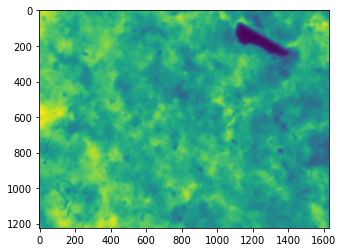

In [4]:
    img_array=cv2.imread("/content/drive/MyDrive/photos_test/tuberculosis-phone-0001.jpg",0)
    plt.imshow(img_array)
    plt.show()




In [14]:
train_images=[]
train_labels=[]

paths = "photos_test"
annot = "anotations_test"

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("tuberculosis"):
            filename=i.split(".")[0]+".jpg"
            image=cv2.imread(os.path.join(paths,filename))
            df=pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e<2000 and flag ==0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue





inside


Once the step above is completed we will have one object conaining all the images that we are going to use for training. Notice that as we restricted it to 30 images for both false and true objects the dataset for predicting the outcome will be more or less well-balanced.

Within the train_images we have all the sections from the real images whereas in train_label we have a list including the index of those images that are background (0) or bacillus (1).

To work easily with these objects we are going to convert them to numpy objects.

In [16]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

X_new.shape
y_new.shape
#im=X_new[200,:,:,:]
#plt.imshow(im)
#plt.show()

#X_new.tofile("X_new.dat")
#np.savetxt('Y_new.txt', y_new, fmt='%d')

#X_nw = np.fromfile('X_new.dat', dtype=int)

(39526,)

In [18]:
print(X_new.shape)
print(y_new.shape)

np.save("X_new.npy",X_new)
#x=np.load("X_new.npy")
#x.shape

(39526, 224, 224, 3)
(39526,)


In [19]:
import numpy as np
X_nw = np.fromfile('X_new.dat')
print(X_nw)
X_nw.shape

[-1.46725751e-117 -3.43020275e-084 -2.02745071e-175 ...  3.45751833e+175
  8.31182021e+151  8.18603976e+271]


(743852928,)

Now we will take advantage of the framework Keras, which is one of the most used for deep learning projects.

First we will import the function Dense from keras.layers, which implements the activation function of the network.

Then, Models groups all the layers into a single object with training and inference features.

With optimizers we can make the model to learn from itself.

IMageDataGenerator not used

Then keras.application includes models that have already pre-trained weights. In pur case we eill used VGG16.

- include_top: whether to include the 3 fully-connected layers at the top of the network.
- weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.


In [26]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

#vggmodel = VGG16(weights='imagenet')
#vggmodel.summary()
vggmodel=keras.models.load_model("vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x155375660>.

Once we have our model selected we are going to do transfer learning on the image weight. 

Transferlearning consists on taking advantage on a model that is already traind with much more data and take those layers that can be improved for our problem. This way we will train the layers selected to obtain better results. Therefore we will freeze the first 15 layers of the model and not train their weights.

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

Now we select the second last layer of the model and add two unit softmax dense layer as we have two classes to predict (bacillus,background). So we remove the last layer of the VGG2 model which is made to predict 1000 classes.

In [ ]:
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)

Now we put togehter our layers for the final model.

In [ ]:
model_final = Model(vggmodel.input, predictions)

Now as the optimization algorithm we will use the Adaptive Movement Estimation algorith, also refered as ADAM. This algorithm brigns many advantages as it adapts the parameter learning rates based on the average of the second moments of the gradientes (the uncentered variance).

We will set the learning rate as 0.001 and the default values for the others parameters in tensorflow keras are:

- beta1=0.9
- beta2=0.999
- epsilon=1e-08
- decay = 0

In [4]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Now with the method compile we can configure the model for training

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

After creating the model we need to split the dataset into train and test. However, before that we need to one-hot encode the label. Therefore we will use MyLabelBinarizer() function and train_test_split to devide the dataset.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

Now we split both predictors and response in test and training with the function train_test_split from sklearn.

To make sure that the dimensions are the ones we wanted we print it.

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

In order to increase the data that we have we are going to include rotations and flip the image. This way we can make it possible to recognice bacillous independently on its orientation.

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

Now we are going to train the model with the data given. However, before doing that we are going to implement a few methods that will make us get a faster solution. Early stopping will stop the training whenevver a metric has stopped improving.

On the other hand, ModelCheckpoint will take the already computed weights from the model. These weights are already computed as we said before. To get them we use this function.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

Now we fit our model with the data augmented.

In [ ]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 20, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

And plot the results of the fitting

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [ ]:
import joblib
joblib.dump(model_final, 'model_final.pkl')

Now for the data contained in the test with sections of images, we can see the prediction given by the model for each section.

In [ ]:
for image in range(X_test.shape[0]):
  im = X_test[image]
  img = np.expand_dims(im, axis=0)
  out= model_final.predict(img)

  if out[0][0] > out[0][1]:
    plt.figure()
    im = X_test[image]
    plt.imshow(im)


Now we can do predictions with the model fitted over some images saved for testing. Here we take each testing picture and do selective search over it. Now for each section of the image we will predict if it is a bacillus or not with the trained model. If the result of the network is higher than 0.65 we assume that it is a bacillus and we write a box over it.

In [ ]:
z=0
path_test="/content/drive/MyDrive/photos _testing"
anotations_test="/content/drive/MyDrive/anotaciones_testing"

false_negative=0
true_negative=0
true_positive=0
false_positive=0

for e,i in enumerate(os.listdir(anotations_test)):
    if i.startswith("tub"):
        z += 1
        filename=i.split(".")[0]+".jpg"
        img=cv2.imread(os.path.join(path_test,filename))
        df=pd.read_csv(os.path.join(anotations_test,i))
        gtvalues=[]
        for row in df.iterrows():
          x1 = int(row[1][0].split(" ")[0])
          y1 = int(row[1][0].split(" ")[1])
          x2 = int(row[1][0].split(" ")[2])
          y2 = int(row[1][0].split(" ")[3])
          gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()

        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                positive_flag=False
                if out[0][0] > 0.60:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if(iou>0.7):
                          positive_flag=True
                        break
                    if(positive_flag==True):
                      true_positive+=1
                    else:
                      false_positive+=1
                else:
                  for gtval in gtvalues:
                      x,y,w,h = result
                      iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                      if(iou>0.7):
                        positive_flag=True
                      break
                  if(positive_flag==True):
                    false_negative+=1
                  else:
                    true_negative+=1


In [ ]:
      print("Confusion Matrix:")
      print()
      print("     ","prediction")
      print("    ","true"," ","False")
      print("true ",true_positive,"   ",false_positive)
      print("false",false_negative,"   ",true_negative)

      #true_negative+=1
      #print(true_negative)

In [ ]:
z=0
path_test="/content/drive/MyDrive/photos _testing"

for e,i in enumerate(os.listdir(path_test)):
    if i.startswith("tub"):
        z += 1
        img = cv2.imread(os.path.join(path_test,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.80:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)